# 生成对抗模型

Generative Adversarial Network，GAN是一种深度学习模型，属于一种无监督学习的方法。

其目的在于，从数据中学习分布，来得到足以以假乱成真的数据。

为了达到这个目的，通常包含两个基本模型：生成器和判别器。(generative model, G)和(discriminative model, D)

在训练过程中，利用合理的结构和设定，令二者满足纳什均衡，来得到最优解。

## GAN原理

GAN的过程，离不开两个关键内容：生成与对抗。

Goodfellow的例子如下：

```
一个城市中，有一群小偷(生成器)和一群警察（判别器）。

小偷的目的在于，想方设法地欺骗警察；

而警察的目的在于，想方设法地不受欺骗。

```

这样一来，小偷在不断的欺骗和被识破的过程中不断精进技能，从而掌握了更加不易被识破的欺骗技能；

警察则在被欺骗的过程中，不断提高辨识功能，从而对欺骗的细节做出判断，更加接近本质。

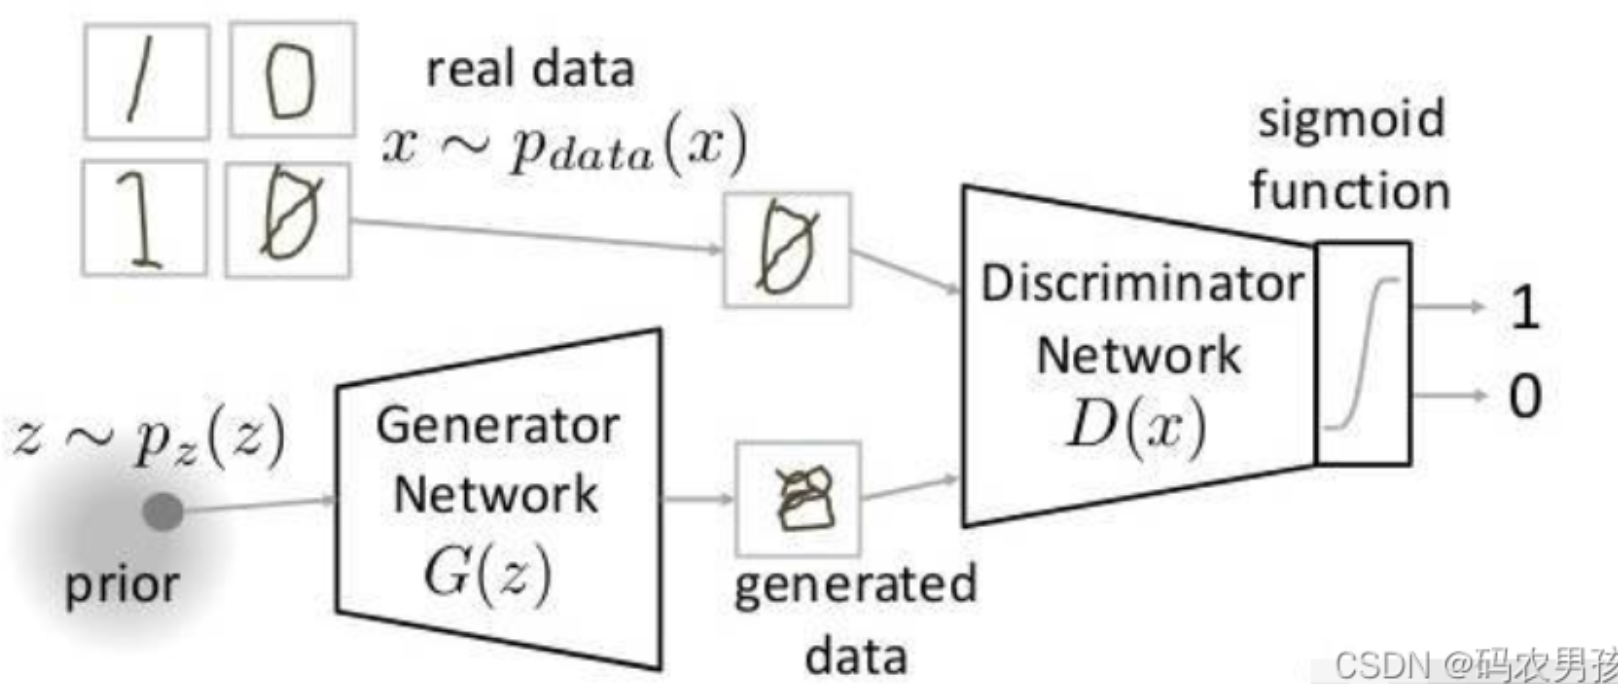

**生成器** 生成器采用随机输入，尝试输出样本数据。根据输入的样本随机产生一个数据，将其送入鉴别器

**鉴别器** 鉴别器的任务在于，接受两个输入，分别是生成器的输入和真实数据，判别器的目的在于判断生成器的输入是不是真的。

### 数学表达

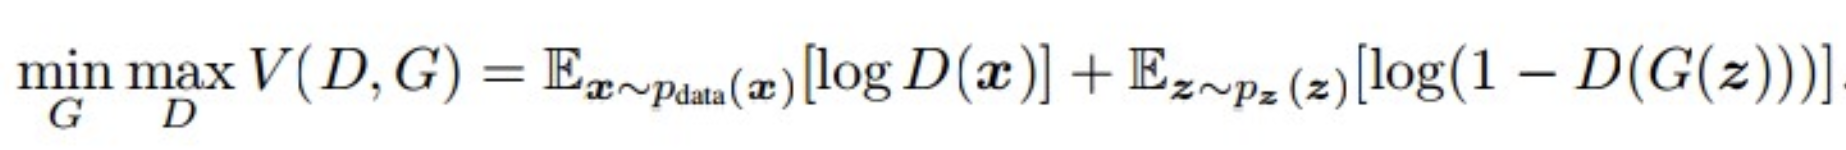

上述过程中，希望判别器能够最大程度地判别出真实数据为真，生成数据为假。

而生成器则是能够最大程度地令判别器产生误判。

## 训练过程

两阶段训练：

1. 固定生成器参数，训练判别器

2. 固定判别器，训练生成器。


GAN模型的训练过程是一个非常复杂的训练过程，早期的GAN训练也非常麻烦。

训练难度之所以大，一个重要的原因在于，难以掌控生成器和判别器的能力。

理论上，如果判别器过于强大，生成器则会由于步长太大无法找到全局最优解。

一个简单的例子在于，人类现代科技无法从外星人科技中吸收影响，从而无法引发科技进步。

因此，通常是训练多轮生成器，再训练少轮判别器。

通俗来说，GAN训练的过程应当是一个循序渐进，相辅相成的过程。如果一开始，通过载入与训练模型令判别器具有很高的能力，往往会令GAN难以有效收敛。

### 代码实践


[参考](https://blog.csdn.net/m0_62128864/article/details/123853830)

In [43]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

from tqdm import tqdm

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(.5, .5)
])

train_data = torchvision.datasets.MNIST('data', 
                                        train=True,
                                        transform=transform,
                                        download=True)

dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [37]:
# generator
class Gen(nn.Module):
    def __init__(self):
        super(Gen, self).__init__()
        self.gen = nn.Sequential(nn.Linear(100, 256), 
                                 nn.ReLU(),
                                 nn.Linear(256, 512), 
                                 nn.ReLU(), 
                                 nn.Linear(512, 28*28), 
                                 nn.Tanh())
    
    def forward(self, x):
        img = self.gen(x)
        img = img.view(-1, 28, 28)
        return img

In [38]:
# discriminator
class Dis(nn.Module):
    def __init__(self):
        super(Dis, self).__init__()
        self.dis = nn.Sequential(nn.Linear(28*28, 512), 
                                 nn.LeakyReLU(),
                                 nn.Linear(512, 256), 
                                 nn.LeakyReLU(), 
                                 nn.Linear(256, 1),
                                 nn.Sigmoid())
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dis(x)
        return x

In [40]:
gen = Gen().to('cpu')
dis = Dis().to('cpu')

d_optim = torch.optim.Adam(dis.parameters(), lr=1e-4)
g_optim = torch.optim.Adam(gen.parameters(), lr=1e-4)

loss_func = torch.nn.BCELoss()

In [103]:
# train
loss_d = []
loss_g = []

for epoch in range(50):
    d_epoch_loss = 0
    g_epoch_loss = 0
    batch_count = len(dataloader)
    
    for i, (img, _) in enumerate(tqdm(dataloader)):
        img = img.to('cpu')
        size = img.size(0)
        random_noise = torch.randn(size, 100, device='cpu')
        
        d_opt.zero_grad()
        real_output = dis(img)
        d_real_loss = loss_func(real_output, 
                                torch.ones_like(real_output))
        d_real_loss.backward()
        
        gen_img = gen(random_noise)
        fake_output = dis(gen_img.detach())
        d_fake_loss = loss_func(fake_output, 
                                torch.zeros_like(fake_output))
        d_fake_loss.backward()
        
        d_loss = d_real_loss + d_fake_loss
        d_optim.step()
        
        g_optim.zero_grad()
        fake_output = dis(gen_img)
        g_loss = loss_func(fake_output, 
                           torch.ones_like(fake_output))
        
        g_loss.backward()
        g_optim.step()
    
        torch.save(gen.state_dict(), str(epoch).zfill(2) + ".pth")

 57%|███████████████████████▍                 | 537/938 [00:12<00:09, 41.52it/s]


KeyboardInterrupt: 

In [96]:
# show result
def result_show(weight, test_input):
    gen = Gen().to('cpu')
    gen.load_state_dict(torch.load(weight))
    gen.eval()
    plot_img(gen, test_input)

In [104]:
# plot image
import matplotlib.pyplot as plt

def plot_img(model, _input):
    prediction = model(_input).detach().cpu().numpy()
    print(prediction.shape)
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow((prediction[i]+1)/2)
        plt.axis('off')
    plt.show()

(64, 28, 28)


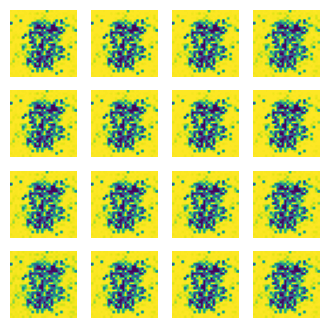

In [105]:
random_noise = torch.randn(16, 100)
import numpy as np

result_show('./00.pth', random_noise)